In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv("data/creditcard.csv").drop(columns=['Time'])

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(df.Class.value_counts())
print(f"Total fraud: {len(df[df.Class == 1])/len(df): .1%}")

0    284315
1       492
Name: Class, dtype: int64
Total fraud:  0.2%


In [4]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

<AxesSubplot: xlabel='Class', ylabel='Amount'>

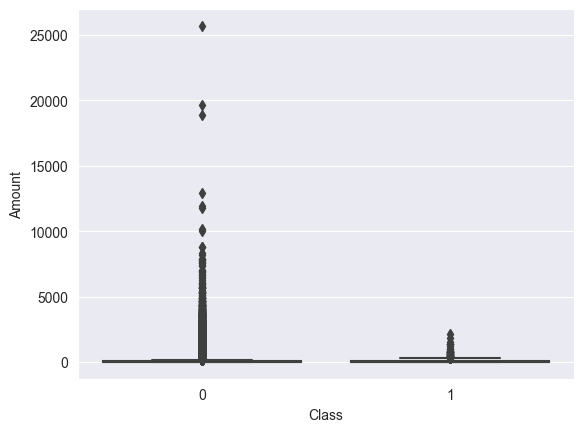

In [5]:
sns.boxplot(data=df, x='Class', y='Amount')

In [6]:
from imblearn.under_sampling import RandomUnderSampler

df_sampled, y_sampled = (
    RandomUnderSampler(sampling_strategy=.05, random_state=0)
    .fit_resample(df.drop(columns='Class'), df.Class)
)

df_sampled['Class'] = y_sampled

/Users/hamed/.pyenv/versions/3.10.0/envs/gdsenv/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/Users/hamed/.pyenv/versions/3.10.0/envs/gdsenv/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/Users/hamed/.pyenv/versions/3.10.0/envs/gdsenv/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


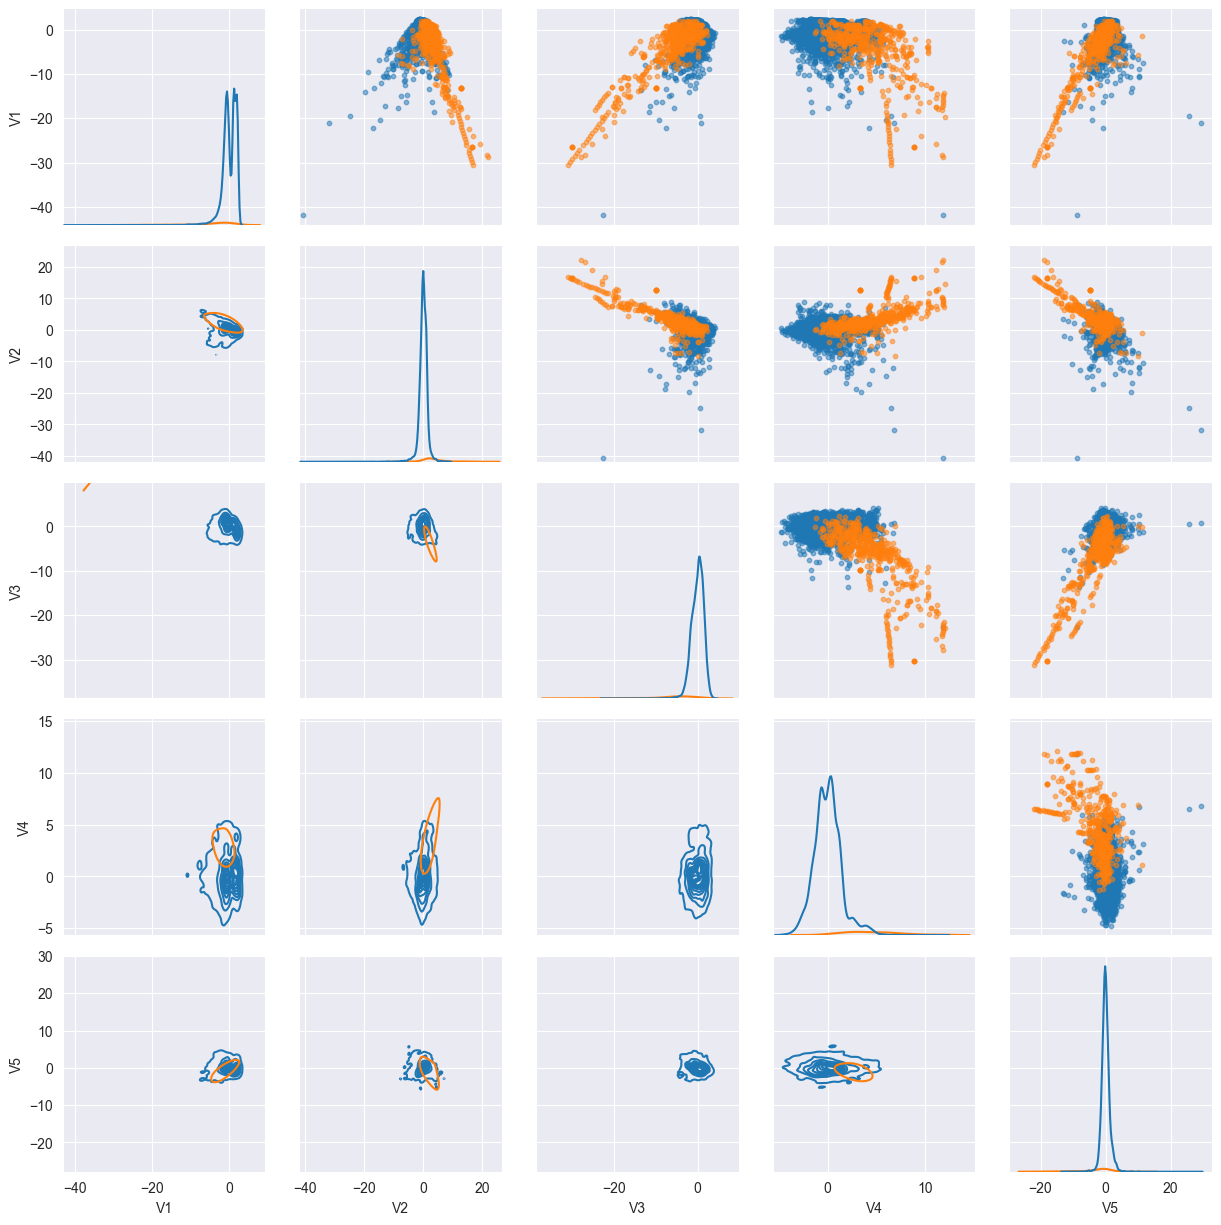

In [7]:
plot_grid = sns.PairGrid(data=df_sampled, vars=[f'V{i}' for i in range(1, 6)], hue='Class')

plot_grid = plot_grid.map_upper(plt.scatter, alpha=.5, s=10)
plot_grid = plot_grid.map_lower(sns.kdeplot)
plot_grid = plot_grid.map_diag(sns.kdeplot)

# Classification

- precision and recall
- ROC curve
- Undersampling

In [8]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler

RobustScaler: 

$$
X_{scale} = \frac{x_i - x_{med}}{x_{75} - x_{25}}
$$

In [9]:
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': [1, .1, .01, .001],
    'kernel': ['rbf'] #, 'poly', 'sigmoid']
}

# the first step of the pipeline is basically onehotencodes the categorical variables. 
pipeline = Pipeline([
    (
        'prep',  
        make_column_transformer(
            (RobustScaler(), ["Amount"]),
            remainder="passthrough"   # to keep the other columns in
        )
    ), 
    (
        'grid_search', 
         GridSearchCV(
            estimator = SVC(probability=True), 
            param_grid= param_grid, 
            cv = StratifiedKFold(3), # Stratified k-fold
            verbose=2, 
            n_jobs = 8
        )
    )
])

In [10]:
X = df.drop(columns=['Class'])
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_sampled, y_train_sampled = (
    RandomUnderSampler(sampling_strategy=.05, random_state=0)
    .fit_resample(X_train, y_train)
)

In [11]:
print(f"% of fraud in train: {y_train.sum()/len(y_train):.1%}")
print(f"% of fraud in test: {y_test.sum()/len(y_test):.1%}")
print(f"% of fraud in sampled train: {y_train_sampled.sum()/len(y_train_sampled):.1%}")

% of fraud in train: 0.2%
% of fraud in test: 0.2%
% of fraud in sampled train: 4.8%


In [12]:
pipeline.fit(X_train_sampled, y_train_sampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['Amount'])])),
                ('grid_search',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=SVC(probability=True), n_jobs=8,
                              param_grid={'C': [0.1, 1, 10, 100],
                                          'gamma': [1, 0.1, 0.01, 0.001],
                                          'kernel': ['rbf']},
                              verbose=2))])

In [13]:
pred_prob = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

In [14]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

print()
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print()
print("Classification report:")
print(metrics.classification_report(y_test, y_pred))

Accuracy:  0.998735999438222

Confusion matrix:
[[85213    82]
 [   26   122]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.60      0.82      0.69       148

    accuracy                           1.00     85443
   macro avg       0.80      0.91      0.85     85443
weighted avg       1.00      1.00      1.00     85443



Text(0.5, 1.0, 'ROC Curves(AUC: 0.9524340009157407)')

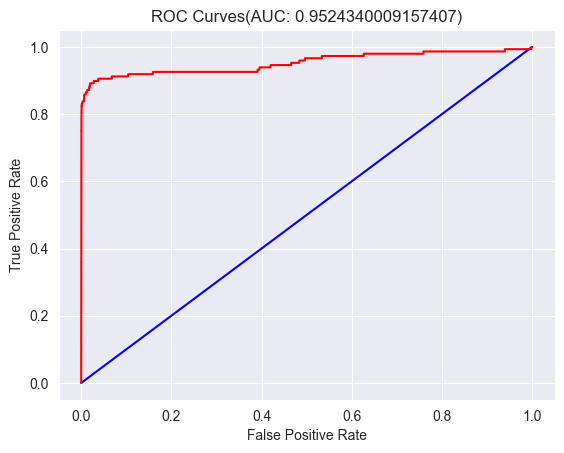

In [15]:
base_fpr, base_tpr, _ = metrics.roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = metrics.roc_curve(y_test, pred_prob[:, 1])

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves(AUC: {metrics.auc(model_fpr, model_tpr)})')

# Anomaly detection

- Isolation forest
- Compare with the classification

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
outlier_fraction = y_train.sum()/len(y_train)

iforest = IsolationForest(
    n_estimators=100, max_samples=len(X_train), 
    contamination=outlier_fraction, 
    random_state=42, verbose=0
)

iforest.fit(X_train)

/Users/hamed/.pyenv/versions/3.10.0/envs/gdsenv/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.0017254870488152324, max_samples=199364,
                random_state=42)

In [18]:
y_pred = iforest.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

print()
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print()
print("Classification report:")
print(metrics.classification_report(y_test, y_pred))

Accuracy:  0.9976943693456456

Confusion matrix:
[[85200    95]
 [  102    46]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.33      0.31      0.32       148

    accuracy                           1.00     85443
   macro avg       0.66      0.65      0.66     85443
weighted avg       1.00      1.00      1.00     85443



## Some important notes:
1. We had some important assumptions with classifiers: That all 0 labled data are actually not fraud. This is not correct!
2. We did a huge undersampling
3. Conceptually the right approach is the anomaly detection. 
4. The right score here is just how many frauds are detected in the test data. The confusion matrix does not tell us much.

# Bonus: Under (Over)-sampeling

In [19]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [20]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

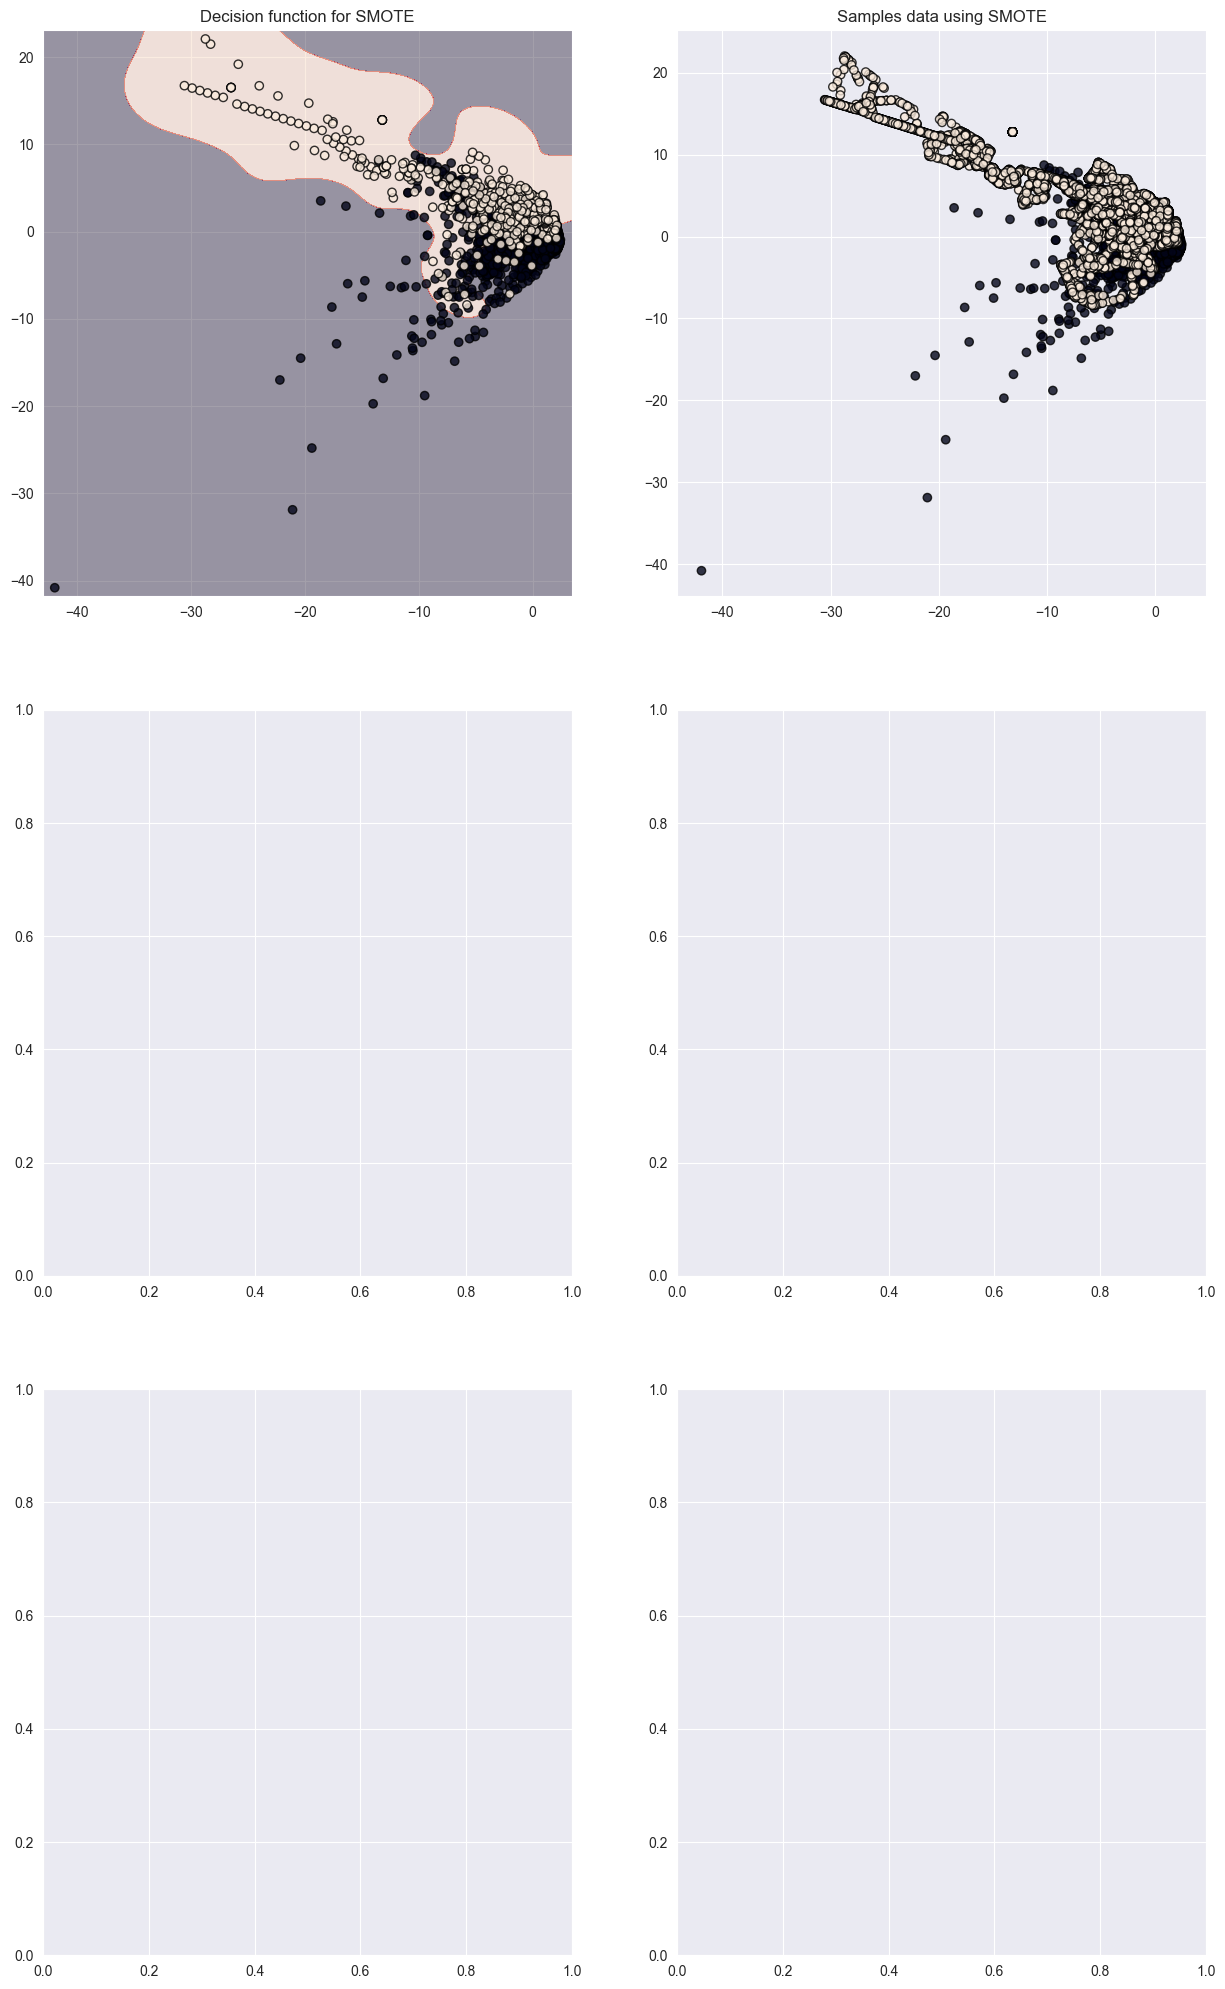

In [31]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 25))
X_2, y_2 = df_sampled[['V1', 'V2']].values, df_sampled['Class'].values

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
for ax, sampler in zip(
    ax_arr, (
        SMOTE(random_state=0),
        # SMOTEENN(random_state=0),
        # SMOTETomek(random_state=0)
    )
):
    clf = make_pipeline(sampler, SVC(gamma=.1, kernel='rbf'))
    clf.fit(X_2, y_2)
    
    plot_decision_function(X_2, y_2, clf, ax[0])
    ax[0].set_title(f'Decision function for {sampler.__class__.__name__}')
    
    X_sample, y_sample = sampler.fit_resample(X_2, y_2)
    ax[1].scatter(X_sample[:, 0], X_sample[:, 1], c=y_sample, alpha=0.8, edgecolor='k')
    ax[1].set_title(f'Samples data using {sampler.__class__.__name__}')